In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv("e-shop clothing 2008.csv", delimiter=';')
df.head()

,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1


In [ ]:
df.dtypes

year                        int64
month                       int64
day                         int64
order                       int64
country                     int64
session ID                  int64
page 1 (main category)      int64
page 2 (clothing model)    object
colour                      int64
location                    int64
model photography           int64
price                       int64
price 2                     int64
page                        int64
dtype: object

In [ ]:
df['page 2 (clothing model)'].value_counts()

page 2 (clothing model)
B4     3579
A2     3013
A11    2789
P1     2681
B10    2566
       ... 
P66      46
P22       2
P79       2
P54       1
P28       1
Name: count, Length: 217, dtype: int64

In [ ]:
# df = df[df['page 2 (clothing model)'].str.isnumeric()]

In [ ]:
# df['page 2 (clothing model)'] = pd.to_numeric(df['page 2 (clothing model)'])

In [ ]:
encoders = {}
for col in df.columns:
    if df[col].dtype == 'object':
            label_encoder = LabelEncoder()
            df[col] = label_encoder.fit_transform(df[col])
            encoders[col] = label_encoder
df["price 2"] = df["price 2"] - 1

Text(0.5, 1.0, 'pearson correlation')

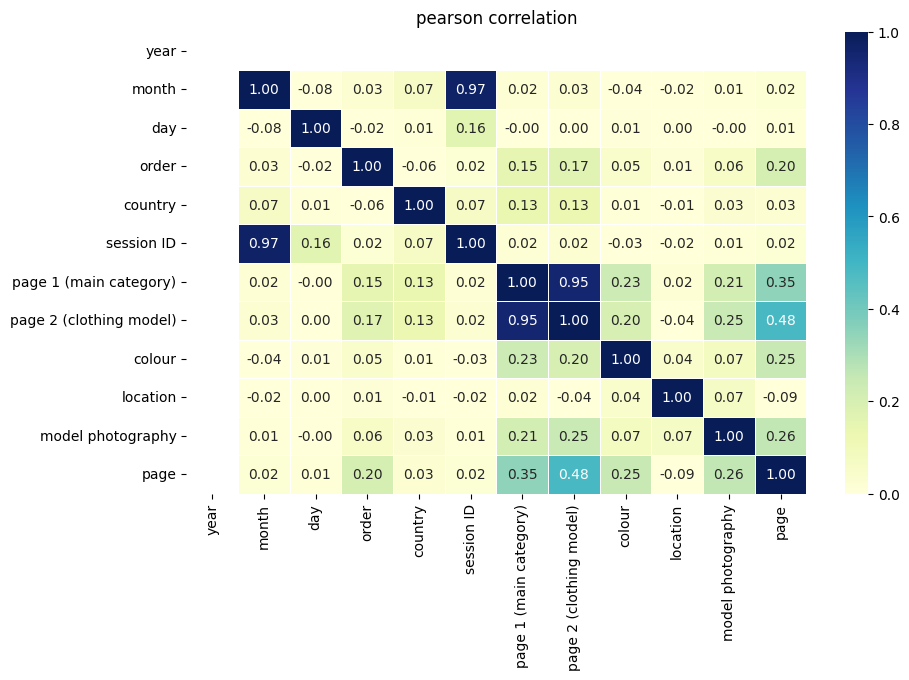

In [ ]:
df_copy2 = df.drop(['price','price 2'], axis=1)
df_copy2['year'] = pd.to_numeric(df_copy2['year'], errors='coerce')
plt.figure(figsize=(10,6))
corr_matrix = df_copy2.corr(method="pearson")
for col in corr_matrix.columns:
    if not pd.api.types.is_numeric_dtype(corr_matrix[col]):
        print(f"Warning: Column '{col}' in the correlation matrix is not numeric.")
sns.heatmap(corr_matrix, vmin=0, vmax=1, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

In [ ]:
y = df["price"]
X = df.drop('price',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state = 42)

In [ ]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

page 1 (main category)     0.497263
price 2                    0.443736
page 2 (clothing model)    0.326703
colour                     0.214515
location                   0.178634
page                       0.164535
model photography          0.064868
country                    0.007325
day                        0.003987
order                      0.003936
year                       0.001489
session ID                 0.000753
month                      0.000666
dtype: float64

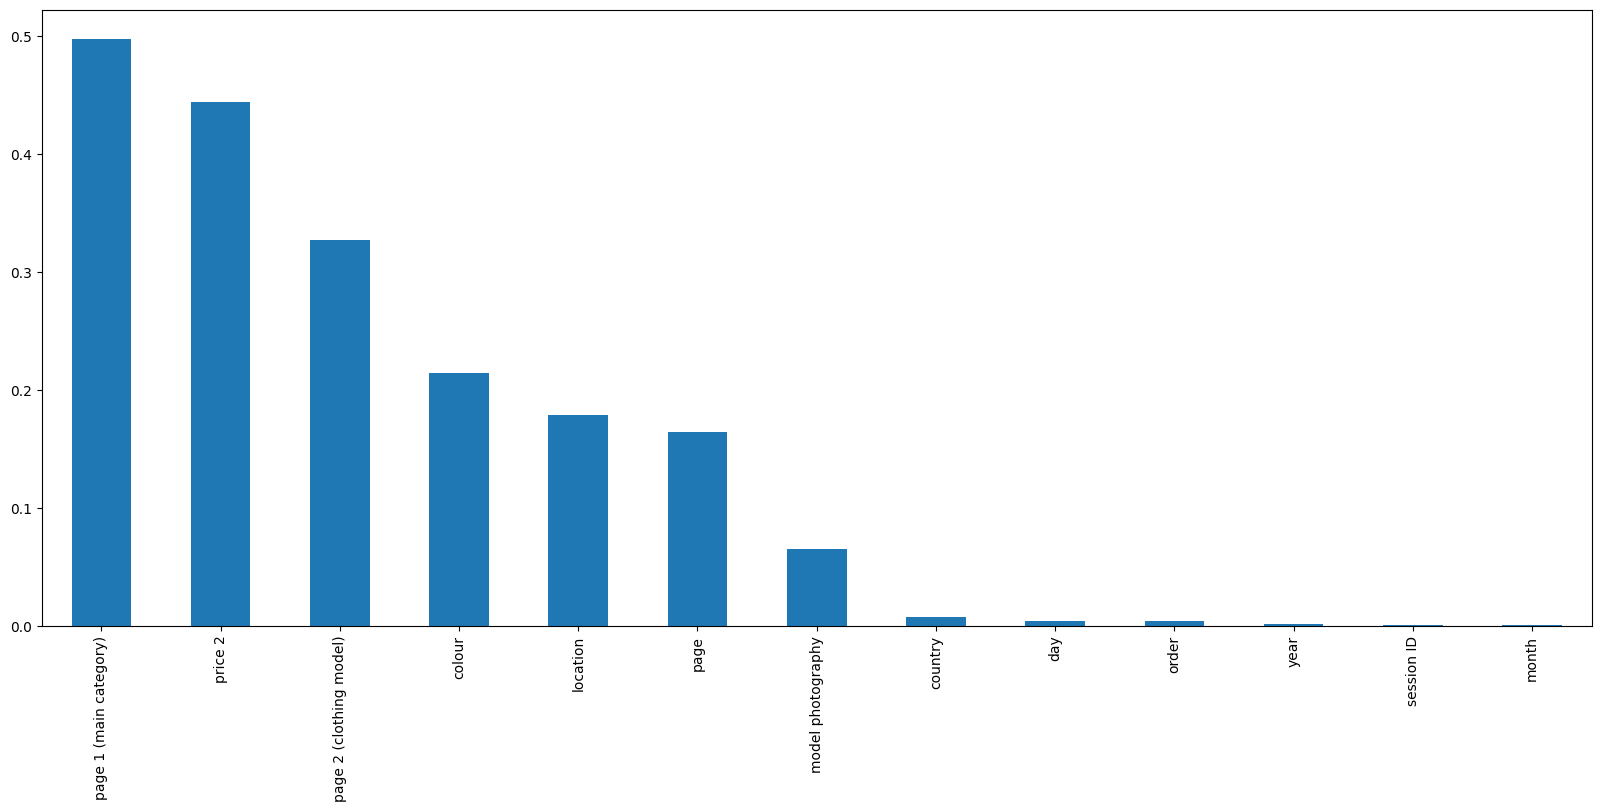

In [ ]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8));

In [ ]:
from sklearn.feature_selection import SelectKBest
sel_five_cols = SelectKBest(mutual_info_classif, k=6)
sel_five_cols.fit(X_train, y_train)
X_train.columns[sel_five_cols.get_support()]

Index(['page 1 (main category)', 'page 2 (clothing model)', 'colour',
       'location', 'price 2', 'page'],
      dtype='object')

In [ ]:
if 'lasso' not in globals():
    # Create the variable 'lasso'
    from sklearn.linear_model import Lasso
    lasso = Lasso(alpha=1.0)
    lasso.fit(X_train, y_train)

selected_feature_names = X_train.columns[lasso.coef_ != 0]

new_features=[]
# Print selected feature names
# print("Selected feature names:")
for feature_name in selected_feature_names:
    new_features.append(feature_name)
print('List of features having Non Zero Coefficient:',new_features)
print('Total Number of New Features:',len(new_features))

List of features having Non Zero Coefficient: ['session ID', 'page 2 (clothing model)', 'colour', 'location', 'price 2']
Total Number of New Features: 5


In [ ]:
X_selected = df[new_features]
y = df['page']
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming you have your data X and y
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Initialize the SVC classifier with RBF kernel and hyperparameter C=10
svm_classifier = SVC(kernel='rbf', C=10)

# Train the model
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_test = svm_classifier.predict(X_test)

# Evaluate the model
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy on test set:", accuracy_test)

# Initialize Logistic Regression as the estimator for RFE
logistic_regression = LogisticRegression()

# Initialize RFE with Logistic Regression as the estimator
rfe = RFE(estimator=logistic_regression, n_features_to_select=2, step=1)

# Fit RFE on the training data
rfe.fit(X_train, y_train)

# Get the selected feature indices
selected_feature_indices = rfe.support_

# Get the selected feature names
selected_feature_names = X_selected.columns[selected_feature_indices]

# Print selected feature names
# print("Selected feature names:")
# for feature_name in selected_feature_names:
#     print(feature_name)


Accuracy on test set: 0.5685148814020244


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
print("Selected feature names:")
feature_names = []
for feature_name in selected_feature_names:
    feature_names.append(feature_name)
feature_names

Selected feature names:


['location', 'price 2']

In [ ]:
print("New Dataset after variable selection using Bi directional elimination")
X_new = df[feature_names]
X_new

New Dataset after variable selection using Bi directional elimination


,location,price 2
0,5,1
1,6,1
2,2,0
3,6,1
4,3,0
...,...,...
165469,4,0
165470,4,0
165471,1,1
165472,1,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.20, stratify= y)

# Initialize the SVC classifier with RBF kernel and hyperparameter C=10
svm_classifier = SVC(kernel='rbf', C=10)

# Train the model
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_train = svm_classifier.predict(X_train)

# Evaluate the model
bi_accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy on train set:", bi_accuracy)

Accuracy on train set: 0.5647496959487532
